### Multi-Layer Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from dataset import mnist
from util import (
    get_torch_size_string,
    print_model_parameters,
    print_model_layers,
    model_train,
    model_eval,
    model_test
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Hyperparameters

In [2]:
device      = 'cpu'
n_epoch     = 20
batch_size  = 128
print_every = 1
print ("Ready.")

Ready.


### Dataset

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
print ("MNIST ready.")

MNIST ready.


### Model

In [4]:
class MultiLayerPerceptronClass(th.nn.Module):
    def __init__(
        self,
        name       = 'mlp',
        x_dim      = 784,
        h_dim_list = [256,256],
        y_dim      = 10,
        actv       = nn.ReLU(),
        p_drop     = 0.2
    ):
        """
            Initialize MLP
        """
        super(MultiLayerPerceptronClass,self).__init__()
        self.name       = name
        self.x_dim      = x_dim
        self.h_dim_list = h_dim_list
        self.y_dim      = y_dim
        self.actv       = actv
        self.p_drop     = p_drop
        
        # Declare layers
        self.layer_list = []
        h_dim_prev = self.x_dim
        for h_dim in self.h_dim_list:
            # dense -> batchnorm -> actv -> dropout
            self.layer_list.append(nn.Linear(h_dim_prev,h_dim))
            self.layer_list.append(nn.BatchNorm1d(num_features=h_dim))
            self.layer_list.append(self.actv)
            self.layer_list.append(nn.Dropout1d(p=self.p_drop))
            h_dim_prev = h_dim
        self.layer_list.append(nn.Linear(h_dim_prev,self.y_dim))
        
        # Define net
        self.net = nn.Sequential()
        self.layer_names = []
        for l_idx,layer in enumerate(self.layer_list):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
            self.net.add_module(layer_name,layer)
        
        # Initialize parameters
        self.init_param(VERBOSE=False)
        
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm1d): # init BN
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
        
    def forward(self,x):
        """
            Forward propagate
        """
        intermediate_output_list = []
        for idx,layer in enumerate(self.net):
            x = layer(x)
            intermediate_output_list.append(x)
        # Final output
        final_output = x
        return final_output,intermediate_output_list
    
print ("Ready.")    

Ready.


In [5]:
mlp = MultiLayerPerceptronClass(
    name       = 'mlp',
    x_dim      = 784,
    h_dim_list = [512,256],
    y_dim      = 10,
    actv       = nn.ReLU(),
    p_drop     = 0.25
).to(device)
loss = nn.CrossEntropyLoss()
optm = th.optim.Adam(mlp.parameters(),lr=1e-3)
print ("Ready.")

Ready.


### Print model parameters

In [6]:
print_model_parameters(mlp)

[ 0] parameter:[       net.linear_00.weight] shape:[     512x784] numel:[    401408]
[ 1] parameter:[         net.linear_00.bias] shape:[         512] numel:[       512]
[ 2] parameter:[  net.batchnorm1d_01.weight] shape:[         512] numel:[       512]
[ 3] parameter:[    net.batchnorm1d_01.bias] shape:[         512] numel:[       512]
[ 4] parameter:[       net.linear_04.weight] shape:[     256x512] numel:[    131072]
[ 5] parameter:[         net.linear_04.bias] shape:[         256] numel:[       256]
[ 6] parameter:[  net.batchnorm1d_05.weight] shape:[         256] numel:[       256]
[ 7] parameter:[    net.batchnorm1d_05.bias] shape:[         256] numel:[       256]
[ 8] parameter:[       net.linear_08.weight] shape:[      10x256] numel:[      2560]
[ 9] parameter:[         net.linear_08.bias] shape:[          10] numel:[        10]


### Print model layers

In [7]:
x_torch = th.randn(16,mlp.x_dim).to(device)
print_model_layers(mlp,x_torch)

batch_size:[16]
[  ] layer:[          input] size:[        16x784]
[ 0] layer:[      linear_00] size:[        16x512] numel:[      8192]
[ 1] layer:[ batchnorm1d_01] size:[        16x512] numel:[      8192]
[ 2] layer:[        relu_02] size:[        16x512] numel:[      8192]
[ 3] layer:[   dropout1d_03] size:[        16x512] numel:[      8192]
[ 4] layer:[      linear_04] size:[        16x256] numel:[      4096]
[ 5] layer:[ batchnorm1d_05] size:[        16x256] numel:[      4096]
[ 6] layer:[        relu_06] size:[        16x256] numel:[      4096]
[ 7] layer:[   dropout1d_07] size:[        16x256] numel:[      4096]
[ 8] layer:[      linear_08] size:[         16x10] numel:[       160]


### Train MLP

In [8]:
model_train(mlp,optm,loss,train_iter,test_iter,n_epoch,print_every,device)

epoch:[ 0/20] loss:[1.137] train_accr:[0.9704] test_accr:[0.9631].
epoch:[ 1/20] loss:[1.073] train_accr:[0.9839] test_accr:[0.9727].
epoch:[ 2/20] loss:[1.050] train_accr:[0.9869] test_accr:[0.9746].
epoch:[ 3/20] loss:[1.041] train_accr:[0.9889] test_accr:[0.9783].
epoch:[ 4/20] loss:[1.037] train_accr:[0.9880] test_accr:[0.9772].
epoch:[ 5/20] loss:[1.032] train_accr:[0.9929] test_accr:[0.9798].
epoch:[ 6/20] loss:[1.024] train_accr:[0.9918] test_accr:[0.9754].
epoch:[ 7/20] loss:[1.031] train_accr:[0.9926] test_accr:[0.9779].
epoch:[ 8/20] loss:[1.028] train_accr:[0.9950] test_accr:[0.9779].
epoch:[ 9/20] loss:[1.030] train_accr:[0.9955] test_accr:[0.9807].
epoch:[10/20] loss:[1.017] train_accr:[0.9961] test_accr:[0.9812].
epoch:[11/20] loss:[1.014] train_accr:[0.9968] test_accr:[0.9817].
epoch:[12/20] loss:[1.016] train_accr:[0.9935] test_accr:[0.9752].
epoch:[13/20] loss:[1.023] train_accr:[0.9964] test_accr:[0.9790].
epoch:[14/20] loss:[1.022] train_accr:[0.9974] test_accr:[0.98

### Test MLP

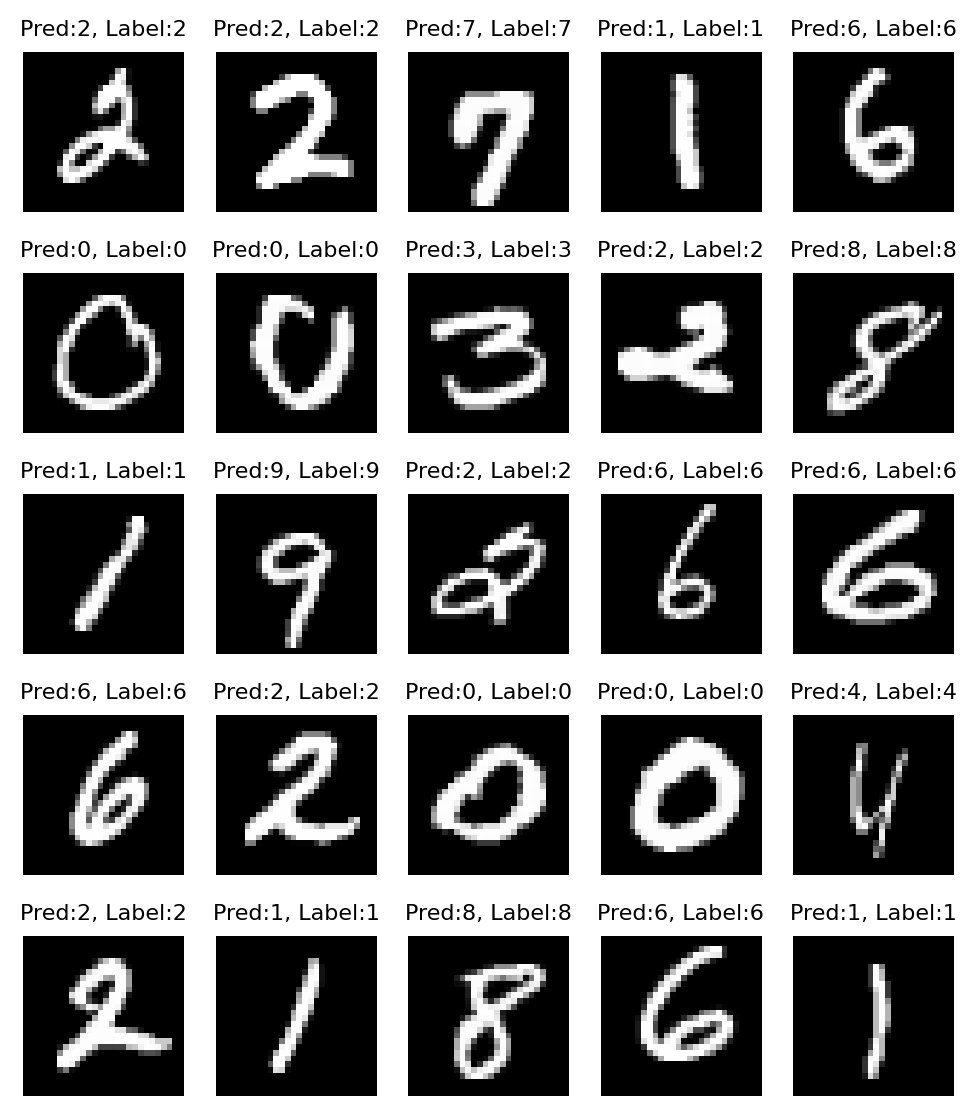

In [9]:
model_test(mlp,test_data,test_label,device)